# NOAA 1158: Setup Heating Models
Simulation of loops in NOAA 1158 in which all of the strands are heated by nanoflares varying frequency. In this notebook, we will setup models for several different heating frequencies, likely low, intermediate, and high.

For all of the models created here, we will use the base AR model of NOAA 1158 that we've already built so that the geometry is consistent across all models.

In [1]:
import os
import logging
import warnings
import multiprocessing
import subprocess
import random
warnings.filterwarnings('ignore')

import numpy as np
from sunpy.map import Map
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import dask.distributed

import synthesizAR
from synthesizAR.model_ext import EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

 using cli
 using CLI for selections
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/ChiantiPy/tools/data.py", line 22, in <module>
    xuvtop = os.environ['XUVTOP']
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/os.py", line 725, in __getitem__
    raise KeyError(key) from None
KeyError: 'XUVTOP'



In [2]:
base_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/base_noaa1158/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-18 18:39:54,445 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-18 18:39:54,445 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-18 18:39:54,446 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-18 18:39:54,447 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-18 18:39:54,448 Parameters: cosmological_simulation   = 0.0


## New Heating Model
This heating model uses the cooling time (as estimated using the loop length) to calculate the number of events and cooling intervals. This ensures that the prescribed heating frequency is occurring on each strand in the AR, independent of loop length (i.e. cooling time).

In [3]:
class CustomHeatingModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        self.logger = logging.getLogger(name=type(self).__name__)
    
    def calculate_event_properties(self,loop):
        self.number_events = self._calculate_number_events(loop)
        rates = self.constrain_distribution(loop)
        delays = (self.number_events*self.heating_options['frequency_parameter']
                  *self.cooling_time(loop)*rates/self.strand_energy(loop))
        running_total = 0.0
        rise_start = np.empty(rates.shape)
        for i in range(self.number_events):
            rise_start[i] = i*self.heating_options['duration'] + running_total
            running_total += delays[i]
        rise_end = rise_start + self.heating_options['duration_rise']
        decay_start = rise_end
        decay_end = rise_start + self.heating_options['duration']
        return {'magnitude':rates,
                'rise_start':rise_start,
                'rise_end':rise_end,
                'decay_start':decay_start,
                'decay_end':decay_end
               }
    
    def _calculate_number_events(self,loop):
        cooling_time = self.cooling_time(loop)
        mean_waiting_period = self.heating_options['frequency_parameter']*cooling_time
        num_events = int(np.floor((self.base_config['total_time'] + mean_waiting_period)/
                                  (self.heating_options['duration'] + mean_waiting_period))) 
        return num_events
    
    def power_law(self,a0,a1,alpha,x):
        return ((a1**(alpha + 1.) - a0**(alpha + 1.))*x + a0**(alpha + 1.))**(1./(alpha + 1.))
    
    def strand_energy(self,loop):
        return ((self.heating_options['stress_level']*loop.field_strength.value.mean())**2)/8./np.pi
    
    def constrain_distribution(self,loop,max_tries=2000,tol=1e-3,**kwargs):
        # initial guess of bounds
        strand_energy = self.strand_energy(loop)
        a0 = 0.5*strand_energy/self.number_events
        a1 = self.heating_options['delta_power_law_bounds']*a0
        # initialize parameters
        tries = 0
        err = 1.e+300
        best_err = err
        while tries < max_tries and err > tol:
            x = np.random.rand(self.number_events)
            h = self.power_law(a0, a1, self.heating_options['power_law_slope'], x)
            pl_sum = np.sum(h)
            chi = strand_energy/pl_sum
            a0 = chi*a0
            a1 = self.heating_options['delta_power_law_bounds']*a0
            err = np.fabs(1.-1./chi)
            if err < best_err:
                best = h
                best_err = err
            tries += 1

        #self.logger.debug("chi = {}, # of tries = {}, error = {}".format(chi, tries, err))

        #if tries >= max_tries:
        #    self.logger.warning("Power-law constrainer reached max # of tries, using best guess with error = {}".format(best_err))

        return np.array(random.sample(list(best), len(best)))
    
    def cooling_time(self,loop):
        half_length = loop.full_length.value/2.
        average_heating_rate_max = self.strand_energy(loop)/(self.heating_options['duration']/2.)#*u.erg/(u.cm**3)/u.s
        # set some constants
        alpha = -0.5
        chi = 6e-20#*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
        kappa_0 = 1e-6#*(u.erg/u.cm/u.s*(u.K**(-7/2)))
        c1,c2,c3 = 2.0,0.9,0.6
        gamma = 5./3.
        # estimate max n0T0
        T0 = c2*(7.*half_length**2*average_heating_rate_max/2./kappa_0)**(2./7.)
        top_term = average_heating_rate_max - 2.*kappa_0*(T0**(3.5))/(7.*(c2**2.5)*c3*(half_length**2)*gamma)
        bottom_term = c1*chi*(T0**alpha)*(1. - c2/c3/gamma)
        n0 = np.sqrt(top_term/bottom_term)
        n0T0 = n0*T0
        # Cargill cooling expression
        term1 = (2. - alpha)/(1. - alpha)
        term2 = (kappa_0**(4. - 2.*alpha))*(chi**7)
        term3 = ((half_length)**(8. - 4.*alpha))/(n0T0**(3+2.*alpha))
        return term1*3.*const.k_B.cgs.value*(1/term2*term3)**(1/(11. - 2.*alpha))

Setup the base heating options. These won't really change except for the frequency parameter.

In [4]:
heating_options = {
    'duration':200.0,
    'delta_power_law_bounds':100.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.1,
    'power_law_slope':-2.5
}

Set base configuration for the EBTEL simulations as well.

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

Setup a runner for doing the EBTEL simulations in parallel.

In [6]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

## High-frequency Heating

First off, load the base field model. We will build all other models off of this one.

In [7]:
high_frequency_field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-18 18:40:01,538 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-18 18:40:01,539 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-18 18:40:01,539 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-18 18:40:01,540 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-18 18:40:01,541 Parameters: cosmological_simulation   = 0.0


Configure the heating model.

In [8]:
high_frequency_heating_options = heating_options.copy()
high_frequency_heating_options['frequency_parameter'] = 0.1
high_frequency_heating_model = CustomHeatingModel(high_frequency_heating_options)
ebtel_interface = EbtelInterface(base_config,high_frequency_heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_high_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_high_frequency/hydro_results/'
                                )

Configure the simulations

In [9]:
high_frequency_field.configure_loop_simulations(ebtel_interface)

Run all of the EBTEL simulations

In [10]:
pool = multiprocessing.Pool()

In [11]:
runs = pool.map_async(ebtel_runner,high_frequency_field.loops)
runs.wait()

And load everything back into the field.

In [12]:
high_frequency_field.load_loop_simulations(ebtel_interface,
                                           savefile='/storage-home/w/wtb2/data/noaa1158_high_frequency/loop_parameters.h5')

Take a look at the hydrodynamic results

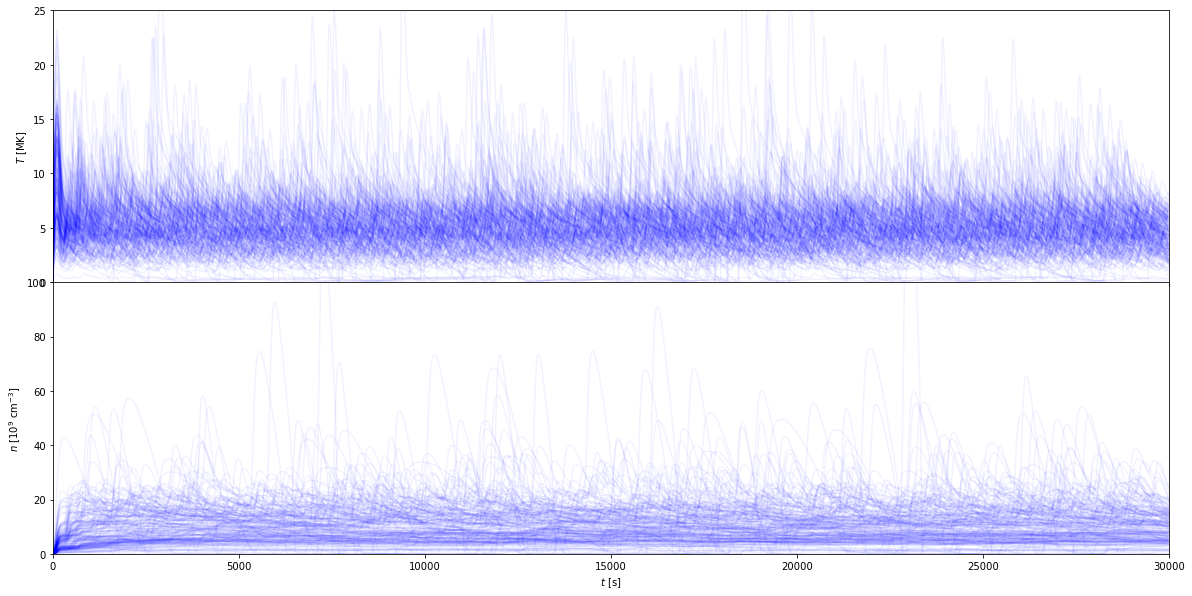

In [14]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in high_frequency_field.loops[::50]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.05)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,100])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Finally, save the field so that we can reload it later if we want.

In [15]:
high_frequency_field.save('/storage-home/w/wtb2/data/noaa1158_high_frequency/field_checkpoint')

## Intermediate-frequency Heating

In [16]:
intermediate_frequency_field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-18 18:52:33,845 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-18 18:52:33,846 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-18 18:52:33,847 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-18 18:52:33,848 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-18 18:52:33,849 Parameters: cosmological_simulation   = 0.0


In [17]:
intermediate_frequency_heating_options = heating_options.copy()
intermediate_frequency_heating_options['frequency_parameter'] = 1.0
intermediate_frequency_heating_model = CustomHeatingModel(intermediate_frequency_heating_options)
ebtel_interface = EbtelInterface(base_config,intermediate_frequency_heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/hydro_results/'
                                )

In [18]:
intermediate_frequency_field.configure_loop_simulations(ebtel_interface)

In [19]:
runs = pool.map_async(ebtel_runner,intermediate_frequency_field.loops)
runs.wait()

In [20]:
intermediate_frequency_field.load_loop_simulations(ebtel_interface,
                                                   savefile='/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/loop_parameters.h5')

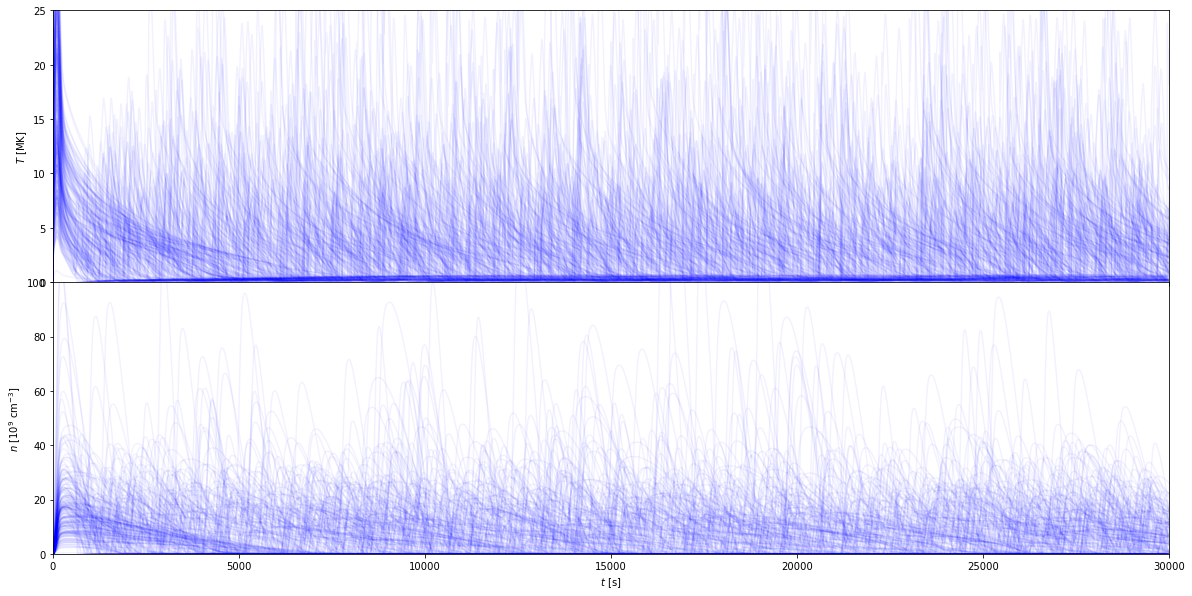

In [22]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in intermediate_frequency_field.loops[::50]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.05)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.05)
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,100])
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [23]:
intermediate_frequency_field.save('/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/field_checkpoint')

## Low-frequency Heating

In [24]:
low_frequency_field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-18 19:06:52,509 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-18 19:06:52,510 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-18 19:06:52,511 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-18 19:06:52,512 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-18 19:06:52,513 Parameters: cosmological_simulation   = 0.0


In [25]:
low_frequency_heating_options = heating_options.copy()
low_frequency_heating_options['frequency_parameter'] = 5.0
low_frequency_heating_model = CustomHeatingModel(low_frequency_heating_options)
ebtel_interface = EbtelInterface(base_config,low_frequency_heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_low_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_low_frequency/hydro_results/'
                                )

In [26]:
low_frequency_field.configure_loop_simulations(ebtel_interface)

In [27]:
runs = pool.map_async(ebtel_runner,low_frequency_field.loops)
runs.wait()

In [28]:
low_frequency_field.load_loop_simulations(ebtel_interface,
                                          savefile='/storage-home/w/wtb2/data/noaa1158_low_frequency/loop_parameters.h5')

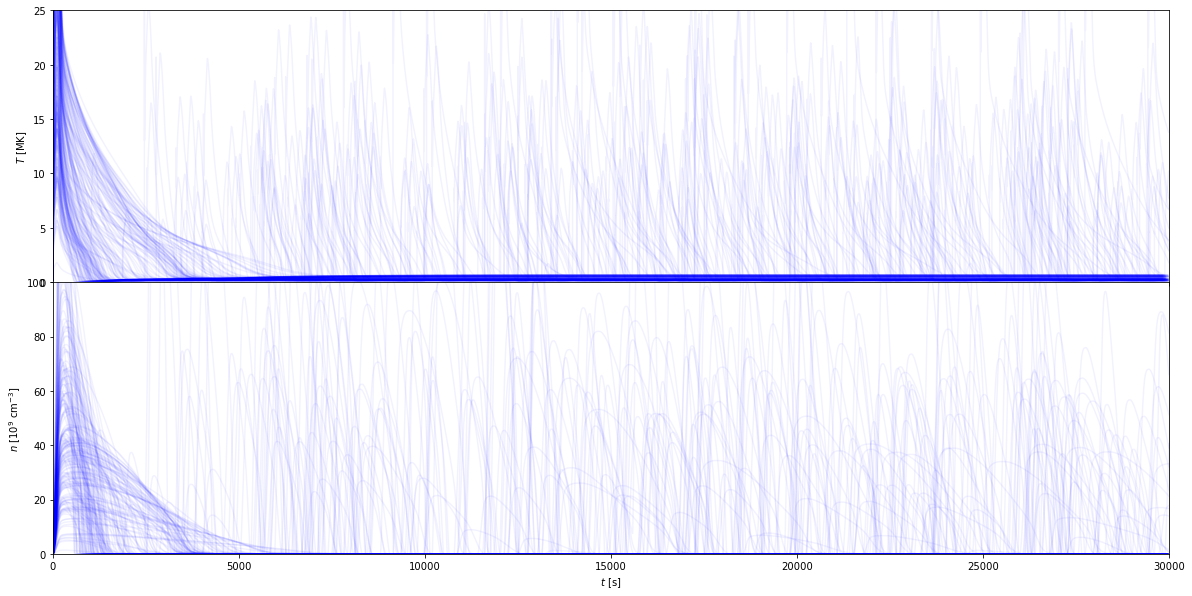

In [31]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in low_frequency_field.loops[::50]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.05)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.05)
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,100])
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [32]:
low_frequency_field.save('/storage-home/w/wtb2/data/noaa1158_low_frequency/field_checkpoint')